In [0]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.optim as O

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
Tesla P100-PCIE-16GB


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
cifar100 = tv.datasets.CIFAR100

In [0]:
train_batch = 256
test_batch = 256

In [0]:
import torchvision.transforms as transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343], std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404])
])

# Normalize test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343], std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404])
])

In [9]:
trainset = tv.datasets.CIFAR100(root='./cifar100/train',
                                         train=True,
                                         download=True,
                                         transform=transform_train)
cifar100_train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=train_batch, shuffle=True, num_workers=4)

testset = tv.datasets.CIFAR100(root='./cifar100/test',
                                        train=False,
                                        download=True,
                                        transform=transform_test)
cifar100_test_loader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch, shuffle=False, num_workers=4)

Extracting ./cifar100/train/cifar-100-python.tar.gz to ./cifar100/train


Extracting ./cifar100/test/cifar-100-python.tar.gz to ./cifar100/test


In [0]:
def conv3x3(in_channels, out_channels, stride=1):
    """3x3 kernel size with padding convolutional layer in ResNet BasicBlock."""
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


class BasicBlock(nn.Module):
    """Basic Block of ReseNet."""

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """Basic Block of ReseNet Builder."""
        super(BasicBlock, self).__init__()

        # First conv3x3 layer
        self.conv1 = conv3x3(in_channels, out_channels, stride)

        #  Batch Normalization
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        # ReLU Activation Function
        self.relu = nn.ReLU(inplace=True)

        # Second conv3x3 layer
        self.conv2 = conv3x3(out_channels, out_channels)

        #  Batch Normalization
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # downsample for `residual`
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """Forward Pass of Basic Block."""
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return out

class ResNet(nn.Module):
    """Residual Neural Network."""

    def __init__(self, block, duplicates, num_classes=100):
        """Residual Neural Network Builder."""
        super(ResNet, self).__init__()

        self.in_channels = 32
        self.conv1 = conv3x3(in_channels=3, out_channels=32)
        self.bn = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.02)

        # block of Basic Blocks
        self.conv2_x = self._make_block(block, duplicates[0], out_channels=32)
        self.conv3_x = self._make_block(block, duplicates[1], out_channels=64, stride=2)
        self.conv4_x = self._make_block(block, duplicates[2], out_channels=128, stride=2)
        self.conv5_x = self._make_block(block, duplicates[3], out_channels=256, stride=2)

        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=1)
        self.fc_layer = nn.Linear(256, num_classes)

        # initialize weights
        # self.apply(initialize_weights)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight.data, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_block(self, block, duplicates, out_channels, stride=1):
        """
        Create Block in ResNet.

        Args:
            block: BasicBlock
            duplicates: number of BasicBlock
            out_channels: out channels of the block

        Returns:
            nn.Sequential(*layers)
        """
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(num_features=out_channels)
            )

        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, duplicates):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)

        return out

In [12]:
lenet5_cifar100 = ResNet(BasicBlock, [3, 4, 6, 3])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [0]:
validate_every = 2000

In [14]:
lenet5_cifar100_dev = lenet5_cifar100.to(device)
opt = O.SGD(lenet5_cifar100.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
scheduler = O.lr_scheduler.MultiStepLR(opt, milestones=[70, 120],gamma=0.1)
criterion = nn.CrossEntropyLoss(reduction="mean")
train_cross_entropy = []
train_accuracy = []
validation_cross_entropy = []
validation_accuracy = []

best_model_accuracy = 0

for epoch in range(500):
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(cifar100_train_loader):
        x, labels = batch
        x, labels = x.to(device), labels.to(device)
        N = x.shape[0]
        
        # training mode (for things like dropout)
        lenet5_cifar100_dev.train()
        
        # clear previous gradients
        opt.zero_grad()
        
        y_hat = lenet5_cifar100_dev(x)
        loss = criterion(y_hat, labels)
        loss.backward()
        opt.step()
        
        train_cross_entropy.append(loss)
        
        n_correct += (torch.argmax(y_hat, dim=1) == labels).sum().item()
        n_total += N
        
        # evaluation mode (e.g. adds dropped neurons back in)
        lenet5_cifar100_dev.eval()
        if i % validate_every == 0:
            n_val_correct = 0
            n_val_total = 0
            v_cross_entropy_sum = 0
            
            # don't calculate gradients here
            with torch.no_grad():
                for j, v_batch in enumerate(cifar100_test_loader):
                    v_x, v_labels = v_batch
                    v_x, v_labels = v_x.to(device), v_labels.to(device)
                    v_N = v_x.shape[0]
                    
                    v_y_hat = lenet5_cifar100_dev(v_x)
                    v_loss = criterion(v_y_hat, v_labels)
                    v_cross_entropy_sum += v_loss
                    n_val_correct += (torch.argmax(v_y_hat, dim=1) == v_labels).sum().item()
                    n_val_total += v_N

            print(f"[epoch {epoch + 1}, iteration {i}] \t accuracy: {n_val_correct / n_val_total} \t cross entropy: {v_cross_entropy_sum / n_val_total}")
            validation_accuracy.append(n_val_correct / n_val_total)
            validation_cross_entropy.append(v_cross_entropy_sum / n_val_total)
            if n_val_correct / n_val_total >= best_model_accuracy:
                best_model_accuracy = n_val_correct / n_val_total
                print("saving")
                torch.save(lenet5_cifar100_dev.state_dict(), './lenet5_cifar100')
    
    print(f"epoch {epoch + 1} accumulated train accuracy: {n_correct / n_total}")
    train_accuracy.append(n_correct / n_total)

[epoch 1, iteration 0] 	 accuracy: 0.01 	 cross entropy: 0.7415557503700256
saving
epoch 1 accumulated train accuracy: 0.08738
[epoch 2, iteration 0] 	 accuracy: 0.1318 	 cross entropy: 0.014704286120831966
saving
epoch 2 accumulated train accuracy: 0.16596
[epoch 3, iteration 0] 	 accuracy: 0.2066 	 cross entropy: 0.013347195461392403
saving
epoch 3 accumulated train accuracy: 0.22384
[epoch 4, iteration 0] 	 accuracy: 0.2295 	 cross entropy: 0.012478957884013653
saving
epoch 4 accumulated train accuracy: 0.2665
[epoch 5, iteration 0] 	 accuracy: 0.2886 	 cross entropy: 0.011491993442177773
saving
epoch 5 accumulated train accuracy: 0.30984
[epoch 6, iteration 0] 	 accuracy: 0.3266 	 cross entropy: 0.01053973101079464
saving
epoch 6 accumulated train accuracy: 0.34982
[epoch 7, iteration 0] 	 accuracy: 0.3505 	 cross entropy: 0.010010012425482273
saving
epoch 7 accumulated train accuracy: 0.38416
[epoch 8, iteration 0] 	 accuracy: 0.385 	 cross entropy: 0.009487569332122803
saving
epo

KeyboardInterrupt: ignored

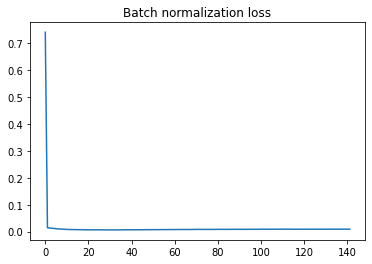

In [15]:
plt.title('Batch normalization loss')
#plt.plot(train_cross_entropy)
plt.plot(validation_cross_entropy)
plt.show()


In [0]:
with open("train_cross_entropy.txt",'w') as f:
  for i in train_cross_entropy: 
    f.write(str(i) + '\n')

with open("validation_cross_entropy.txt",'w') as f:
  for i in validation_cross_entropy: 
    f.write(str(i) + '\n')

with open("train_accuracy.txt",'w') as f:
  for i in train_accuracy:
    f.write(str(i) + '\n')

with open("validation_accuracy.txt",'w') as f:
  for i in validation_accuracy:
    f.write(str(i) + '\n')
